/home/bigdata/disk/data/seizure-prediction/kaggle_data/processed_data/fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30
*********************** Dog_1 ***************************
n_preictal 24
n_inetrictal -480
0.124189080351
           interictal   preictal
interictal        202        276
  preictal          5         19
None
0.791666666667 0.422594142259
*********************** Dog_2 ***************************
n_preictal 42
n_inetrictal -500
0.304451423736
           interictal   preictal
interictal        860         50
  preictal         45         45
None
0.5 0.945054945055
*********************** Dog_3 ***************************
n_preictal 72
n_inetrictal -1440
0.0393517319957
           interictal   preictal
interictal        299        566
  preictal          0         42
None
1.0 0.345664739884
*********************** Dog_4 ***************************
n_preictal 97
n_inetrictal -804
0.117672246824
           interictal   preictal
interictal        810  

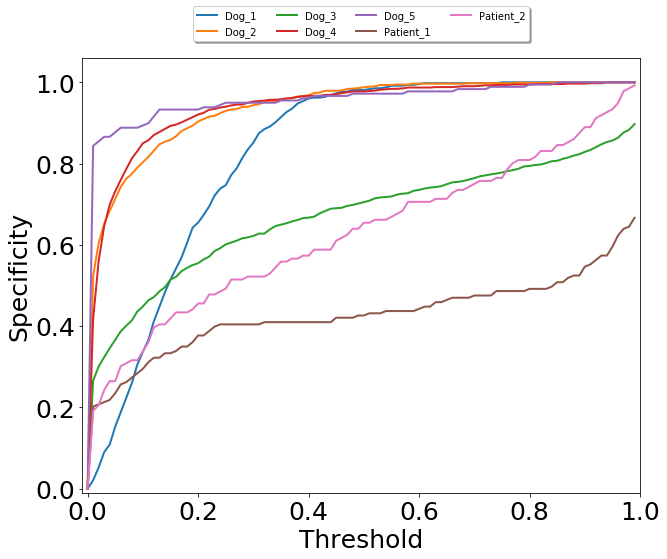

In [5]:
import numpy as np
import json
import os

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#from sklearn.lda import LDA
from sklearn.metrics import confusion_matrix

import preprocessors.fft as fft
from utils.loader import load_test_data, load_train_data
from utils.config_name_creator import *
from commons import reshape_data
from commons import load_test_labels
from commons import print_cm
from sklearn.metrics import roc_curve


def curve_per_subject(subject, data_path, test_labels):
    d = load_train_data(data_path, subject)
    x, y_10m = d['x'], d['y']
    n_train_examples = x.shape[0]
    n_timesteps = x.shape[-1]
    print 'n_preictal', np.sum(y_10m)
    print 'n_inetrictal', np.sum(y_10m - 1)

    x, y = reshape_data(x, y_10m)
    data_scaler = StandardScaler()
    x = data_scaler.fit_transform(x)

    lda = LDA()
    lda.fit(x, y)

    pred_1m = lda.predict_proba(x)[:, 1]
    pred_10m = np.reshape(pred_1m, (n_train_examples, n_timesteps))
    pred_10m = np.mean(pred_10m, axis=1)
    fpr, tpr, threshold = roc_curve(y_10m, pred_10m)
    c = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
    opt_threshold = threshold[np.where(c == np.min(c))[0]][-1]
    print opt_threshold

    # ------- TEST ---------------

    d = load_test_data(data_path, subject)
    x_test, id = d['x'], d['id']
    n_test_examples = x_test.shape[0]
    n_timesteps = x_test.shape[3]
    x_test = reshape_data(x_test)
    x_test = data_scaler.transform(x_test)

    pred_1m = lda.predict_proba(x_test)[:, 1]
    pred_10m = np.reshape(pred_1m, (n_test_examples, n_timesteps))
    pred_10m = np.mean(pred_10m, axis=1)

    y_pred = np.zeros_like(test_labels)
    y_pred[np.where(pred_10m >= opt_threshold)] = 1
    cm = confusion_matrix(test_labels, y_pred)
    print print_cm(cm, labels=['interictal', 'preictal'])
    sn = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
    sp = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print sn, sp

    sn, sp = [], []
    t_list = np.arange(0.0, 1.0, 0.01)
    for t in t_list:
        y_pred = np.zeros_like(test_labels)
        y_pred[np.where(pred_10m >= t)] = 1
        cm = confusion_matrix(test_labels, y_pred)
        sn_t = 1.0 * cm[1, 1] / (cm[1, 1] + cm[1, 0])
        sp_t = 1.0 * cm[0, 0] / (cm[0, 0] + cm[0, 1])
        sn.append(sn_t)
        sp.append(sp_t)

    return t_list, sn, sp


if __name__ == '__main__':
    with open('SETTINGS.json') as f:
        settings_dict = json.load(f)

    data_path = settings_dict['path']['processed_data_path'] + '/' + create_fft_data_name(settings_dict)
    submission_path = settings_dict['path']['submission_path'] + '/LDA_' + create_fft_data_name(settings_dict)
    print data_path

    if not os.path.exists(data_path):
        fft.run_fft_preprocessor()

    if not os.path.exists(submission_path):
        os.makedirs(submission_path)

    test_labels_path = '/home/vitamin/bigdata/code/kaggle-seizure-prediction/test_labels.csv'
    test_labels = load_test_labels(test_labels_path)

    subjects = ['Dog_1', 'Dog_2', 'Dog_3', 'Dog_4', 'Dog_5', 'Patient_1', 'Patient_2']
    t, sn, sp = [], [], []
    for subject in subjects:
        print '***********************', subject, '***************************'
        t_i, sn_i, sp_i = curve_per_subject(subject, data_path, test_labels[subject]['preictal'])
        t.append(t_i)
        sn.append(sn_i)
        sp.append(sp_i)
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(111)
    plt.xlim([-0.01, 1.0])
    plt.ylim([- 0.01, 1.06])
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(25)
    plt.xlabel('Threshold', fontsize=25)

    # plt.ylabel('Sensitivity', fontsize=25)
    # for t_i, sn_i, subject in zip(t, sn, subjects):
    #     plt.plot(t_i, sn_i, label=subject, linewidth=2.0)
    # ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),
    #           ncol=4, fancybox=True, shadow=True, prop={'size': 20})
    # plt.show()

    plt.ylabel('Specificity', fontsize=25)
    for t_i, sp_i, subject in zip(t, sp, subjects):
        plt.plot(t_i, sp_i, label=subject, linewidth=2.0)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),
              ncol=4, fancybox=True, shadow=True, prop={'size': 10})
    plt.show()

In [11]:
import pandas as pd
import json
from pandas import DataFrame
from sklearn.metrics import roc_auc_score

def eval(submission_path):
    print submission_path
    test_labels_path = '/home/vitamin/bigdata/code/kaggle-seizure-prediction/test_labels.csv'
    filenames=['submission','submission_softmax','submission_minmax','submission_median']
    d = DataFrame.from_csv(test_labels_path, index_col=None)
    y_true=d['preictal']
    for fn in filenames:
        sb=pd.read_csv(submission_path+'/'+fn+'.csv')
        y_pred=sb['preictal']
        print fn+ ' Total AUC:'
        print roc_auc_score(y_true,y_pred)
    print 'Job done...'
submission_path='/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30'
eval(submission_path)

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec60stride_sec30
submission Total AUC:
0.747668392662
submission_softmax Total AUC:
0.796765165181
submission_minmax Total AUC:
0.744163411501
submission_median Total AUC:
0.785468332966
Job done...


In [5]:
eval('/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/linear_models/LDA_fft_meanlog_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30
submission Total AUC:
0.746328475458
submission_softmax Total AUC:
0.793087151935
submission_minmax Total AUC:
0.739873297256
submission_median Total AUC:
0.781967677607
Job done...


In [13]:
def eval2(submission_path):
    print submission_path
    with open(submission_path+'/SETTINGS.json') as f:
        dics=json.load(f)
        print dics
    test_labels_path = '/home/vitamin/bigdata/code/kaggle-seizure-prediction/test_labels.csv'
    filenames=['submission','submissionsoftmax','submissionminmax','submissionmedian']
    d = DataFrame.from_csv(test_labels_path, index_col=None)
    y_true=d['preictal']
    for fn in filenames:
        sb=pd.read_csv(submission_path+'/'+fn+'.csv')
        y_pred=sb['preictal']
        print fn+ ' Total AUC:'
        print roc_auc_score(y_true,y_pred)
    
    print 'Job done...'

eval2('/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 1]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl0strid[1, 1]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l120strid120globa1recep[1, 1]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl0strid[1, 1]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission
{u'path': {u'processed_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/processed_data', u'raw_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/raw_data', u'root': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data', u'model_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/models'}, u'model': {u'global_pooling': 1, u'recept_width': [1, 1], u'use_test': 0, u'activation': [u'relu', u'relu', u'tanh'], u'dropout_prob': [0.3, 0.6], u'overlap': 0, u'stride': [1, 1], u'training_batch_size': 10, u'weights_variance': 0.01, u'scale_time': 1, u'nkerns': [16, 32, 512], u'pool_width': [1, 1], u'l2_reg': 0.0001}, u'validation': {u'valid_freq': 10, u'

In [16]:
eval2('/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq8featumeanlog_stdhighc180lowcu0.1win_l30strid30globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl10strid[1, 2]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq8featumeanlog_stdhighc180lowcu0.1win_l30strid30globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl10strid[1, 2]train10weigh0.01scale1nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission
{u'path': {u'processed_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/processed_data', u'raw_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/raw_data', u'root': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data', u'model_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/models'}, u'model': {u'global_pooling': 1, u'recept_width': [1, 2], u'use_test': 0, u'activation': [u'relu', u'relu', u'tanh'], u'dropout_prob': [0.3, 0.6], u'overlap': 10, u'stride': [1, 2], u'training_batch_size': 10, u'weights_variance': 0.01, u'scale_time': 1, u'nkerns': [16, 32, 512], u'pool_width': [1, 1], u'l2_reg': 0.0001}, u'validation': {u'valid_freq': 10, u'

In [21]:
eval2('/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l30strid30globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl0strid[1, 2]train10weigh0.01scale0nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/models/nfreq6featumeanlog_stdhighc180lowcu0.1win_l30strid30globa1recep[1, 2]use_t0activ[urelu, urelu, utanh]dropo[0.3, 0.6]overl0strid[1, 2]train10weigh0.01scale0nkern[16, 32, 512]pool_[1, 1]l2_re0.0001valid10max_i150000rando1/submission
{u'path': {u'processed_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/processed_data', u'raw_data_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/raw_data', u'root': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data', u'model_path': u'/home/bigdata/disk/data/seizure-prediction/kaggle_data/models'}, u'model': {u'global_pooling': 1, u'recept_width': [1, 2], u'use_test': 0, u'activation': [u'relu', u'relu', u'tanh'], u'dropout_prob': [0.3, 0.6], u'overlap': 0, u'stride': [1, 2], u'training_batch_size': 10, u'weights_variance': 0.01, u'scale_time': 0, u'nkerns': [16, 32, 512], u'pool_width': [1, 1], u'l2_reg': 0.0001}, u'validation': {u'valid_freq': 10, u'ma

In [17]:
eval('/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/LSTM_nepoch10_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/LSTM_nepoch10_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30
submission Total AUC:
0.521135869119
submission_softmax Total AUC:
0.432114106008
submission_minmax Total AUC:
0.525148050577
submission_median Total AUC:
0.441789843882
Job done...


In [18]:
eval('/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch50_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30
submission Total AUC:
0.557378520662
submission_softmax Total AUC:
0.441093389742
submission_minmax Total AUC:
0.547842289907
submission_median Total AUC:
0.472917775153
Job done...


In [19]:
eval('/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch1_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30')

/home/bigdata/disk/data/seizure-prediction/kaggle_data/submissions/rnn_model/GRU_nepoch1_fft_meanlog_std_lowcut0.1highcut180nfreq_bands8win_length_sec30stride_sec30
submission Total AUC:
0.519060565555
submission_softmax Total AUC:
0.444764914284
submission_minmax Total AUC:
0.480525779618
submission_median Total AUC:
0.427046428834
Job done...
